<a href="https://colab.research.google.com/github/rachelngordon/BookQuotesAnalysis/blob/main/BookQuotesLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling of Book Quotes using LDA

Sources:

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://maartengr.github.io/BERTopic/getting_started/topicsperclass/topicsperclass.html

## Import the data from Google Drive

In [1]:
# authenticate google user
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# import packages
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# import data from google sheet
worksheet = gc.open('HaleyQuotes').sheet1

rows = worksheet.get_all_values()

df = pd.DataFrame.from_records(rows[1:], columns = rows[0])

# if running on a local computer
#df = pd.read_excel('BookQuotes.xlsx')

In [3]:
# view the data
df.head()

,Text,Author,Book
0,we are dust and shadows,Horace,The Odes of Horace
1,find what you love and let it kill you,Charles Bukowski,
2,the measure of love is to love without measure,Augustine of Hippo,
3,yet each man kills the very thing he loves,Oscar Wilde,Selected Poems of Oscar Wilde
4,"then share thy pain, allow that sad relief",Alexander Pope,Eloisa to Abelard


## Text Preprocessing

In [4]:
## Clean the text
def text_cleaning(text):


  # remove punctuation
  text = re.sub(r"\\n", " ", text)
  text = "".join([char for char in text if char not in string.punctuation])

  # convert to lowercase
  text = text.lower()

  # tokenization (second one removes emojis)
  word_tokens = nltk.word_tokenize(text)

  # remove stop words
  non_stopwords = [word for word in word_tokens if word not in stopwords.words('english') and word not in ['one']] # can adjust second list to exclude words
  text = " ".join(non_stopwords)


  return text


In [5]:
# clean book quotes and add new column to dataframe
clean_quotes = []
for quote in df['Text']:
  clean_quotes.append(text_cleaning(quote))

df['Clean_Text'] = clean_quotes

In [6]:
# if interested in one particular book
#df = df[df['Book'] == 'The Anthropocene Reviewed']

# view new data
df.head()

,Text,Author,Book,Clean_Text
0,we are dust and shadows,Horace,The Odes of Horace,dust shadows
1,find what you love and let it kill you,Charles Bukowski,,find love let kill
2,the measure of love is to love without measure,Augustine of Hippo,,measure love love without measure
3,yet each man kills the very thing he loves,Oscar Wilde,Selected Poems of Oscar Wilde,yet man kills thing loves
4,"then share thy pain, allow that sad relief",Alexander Pope,Eloisa to Abelard,share thy pain allow sad relief


## Exploratory Data Analysis

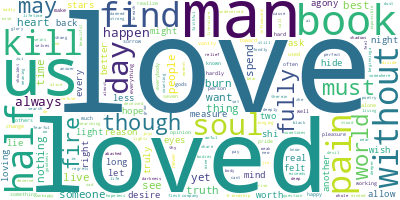

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Clean_Text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Topic Modeling

In [8]:
import gensim
from gensim.utils import simple_preprocess

# preprocess sentences into list of words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.Clean_Text.values.tolist()
data_words = list(sent_to_words(data))
# print first 30 words in first processed sentence
print(data_words[:1][0][:30])

['dust', 'shadows']


In [9]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [10]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"loved" + 0.022*"happen" + 0.022*"happens" + 0.022*"everything" + '
  '0.022*"kill" + 0.022*"would" + 0.012*"sure" + 0.012*"time" + 0.012*"twice" '
  '+ 0.012*"third"'),
 (1,
  '0.049*"fully" + 0.037*"loved" + 0.025*"love" + 0.025*"known" + 0.025*"burn" '
  '+ 0.013*"though" + 0.013*"may" + 0.013*"soul" + 0.013*"else" + '
  '0.013*"stars"'),
 (2,
  '0.032*"love" + 0.032*"shi" + 0.018*"world" + 0.017*"de" + 0.017*"ai" + '
  '0.017*"shang" + 0.017*"zhe" + 0.017*"nothing" + 0.017*"jie" + 0.017*"zui"'),
 (3,
  '0.033*"best" + 0.022*"love" + 0.022*"long" + 0.021*"see" + 0.012*"like" + '
  '0.012*"worth" + 0.012*"much" + 0.012*"anything" + 0.012*"back" + '
  '0.012*"house"'),
 (4,
  '0.041*"books" + 0.028*"half" + 0.028*"change" + 0.028*"us" + 0.015*"would" '
  '+ 0.015*"make" + 0.015*"live" + 0.015*"soul" + 0.015*"reads" + 0.015*"air"'),
 (5,
  '0.025*"man" + 0.025*"always" + 0.025*"pain" + 0.019*"often" + 0.019*"used" '
  '+ 0.013*"truth" + 0.013*"important" + 0.013*"must" + 

## Visualization

In [16]:

!pip install uvicorn
!pip install fastapi
!pip install kaleido
!pip install python-multipart


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00


In [17]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
!pip install --upgrade joblib pandas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
import pickle
import pyLDAvis
import os
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, n_jobs=1)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

### Word Clouds and Counts per topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


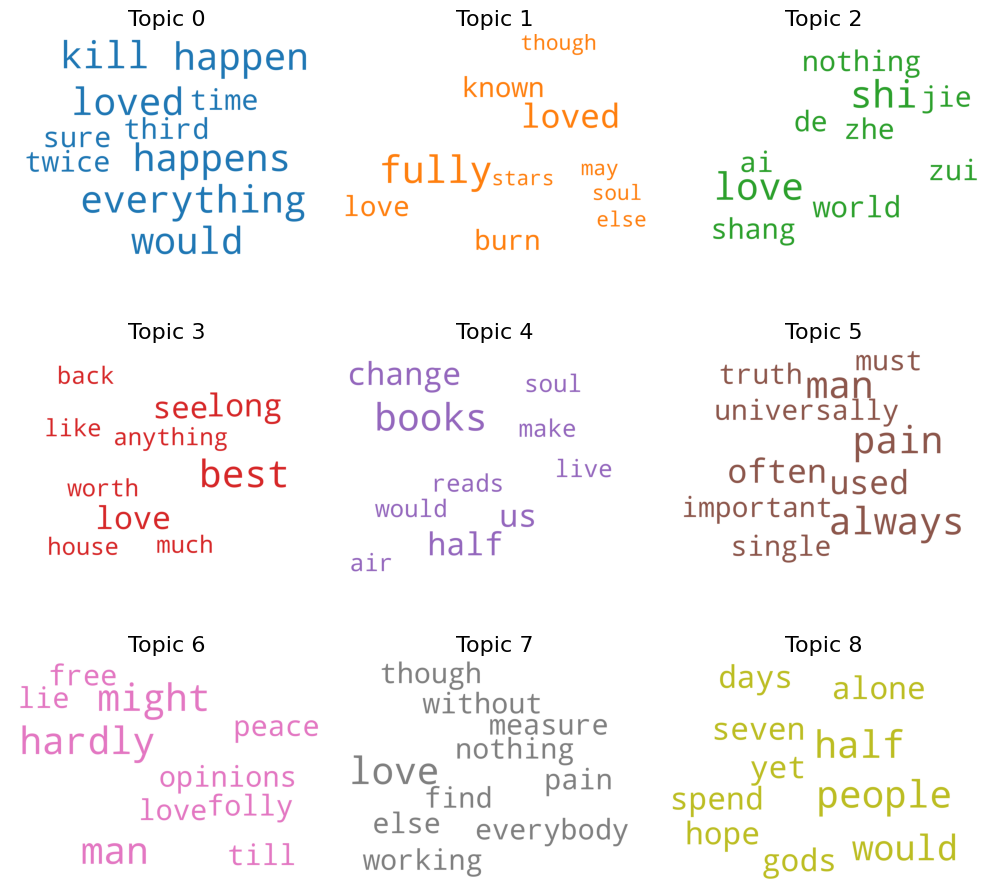

In [24]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-f5158aab08ad>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


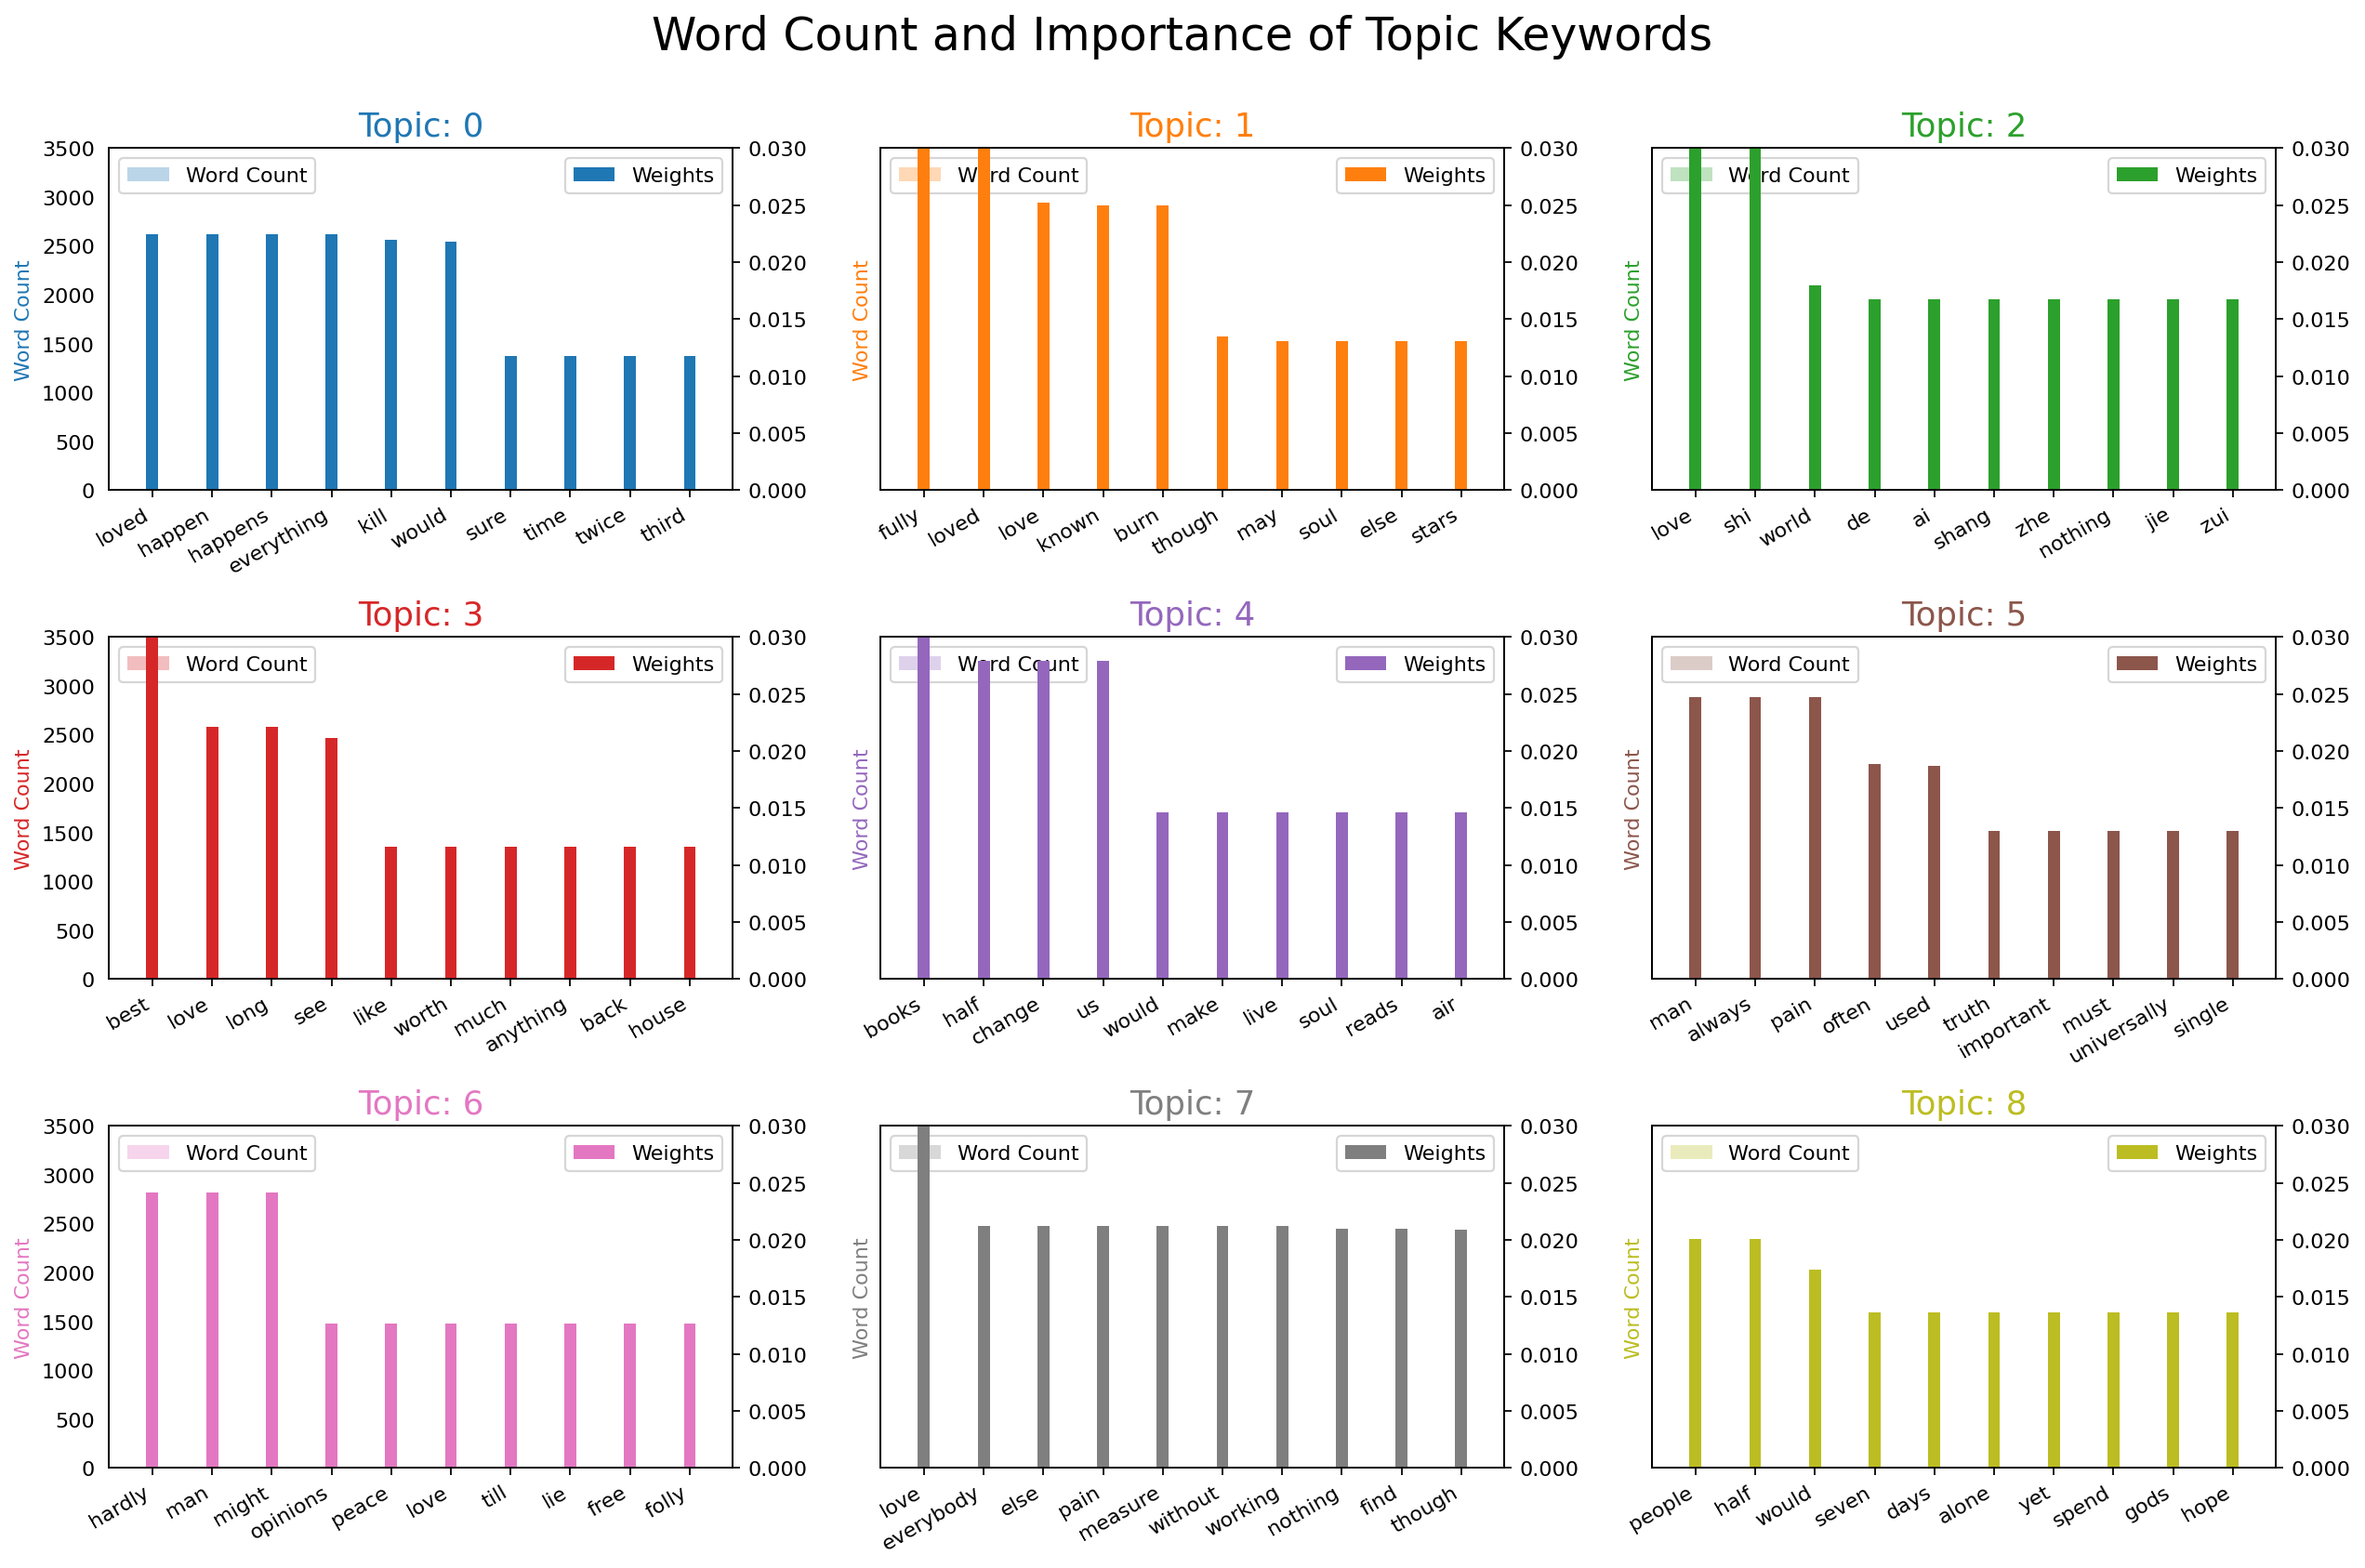

In [25]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()


### Dominant topic for each quote

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))

# write to original dataframe
df["Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]
df["Topic_Perc_Contrib"] = df_dominant_topic["Topic_Perc_Contrib"]
df["Keywords"] = df_dominant_topic["Keywords"]
df.to_csv('CleanQuotes.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-fa389c079f93>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-26-fa389c079f93>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-26-fa389c079f93>:15: FutureWarning: The 

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               0              0.7000   
1            1               7              0.8200   
2            2               7              0.8500   
3            3               1              0.8500   
4            4               7              0.8714   
5            5               4              0.8200   
6            6               8              0.8500   
7            7               0              0.8500   
8            8               6              0.8500   
9            9               7              0.9182   

                                            Keywords  \
0  loved, happen, happens, everything, kill, woul...   
1  love, everybody, else, pain, measure, without,...   
2  love, everybody, else, pain, measure, without,...   
3  fully, loved, love, known, burn, though, may, ...   
4  love, everybody, else, pain, measure, without,...   
5  books, half, change, us, would, make, live, so...   
6  people, ha

### Most representative sentence for each topic

In [27]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
print(sent_topics_sorteddf_mallet.head(10))
sent_topics_sorteddf_mallet.to_csv('Topics.csv')

   Topic_Num  Topic_Perc_Contrib  \
0          0              0.9609   
1          1              0.9357   
2          2              0.9308   
3          3              0.9471   
4          4              0.8875   
5          5              0.9308   
6          6              0.9250   
7          7              0.9250   
8          8              0.9526   
9          9              0.8500   

                                                                        Keywords  \
0      loved, happen, happens, everything, kill, would, sure, time, twice, third   
1                fully, loved, love, known, burn, though, may, soul, else, stars   
2                        love, shi, world, de, ai, shang, zhe, nothing, jie, zui   
3                best, love, long, see, like, worth, much, anything, back, house   
4                   books, half, change, us, would, make, live, soul, reads, air   
5    man, always, pain, often, used, truth, important, must, universally, single   
6              

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
